# Imports

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from src.utils.column_import import columns
from config.settings import saved_models_path
from src.utils.create_figure import evaluate_and_save



s_x, s_y, v_x, v_y, a_x, a_y = columns

 

/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/inD/x_y_recording_00_range_384.csv
/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/scenario_samples/lane_merging/dif_set/test_set_00.csv


## Load models 

In [2]:
# Load the models
def load_model(model_name):
    model_file_path = os.path.join(saved_models_path, f'acceleration_model_5/{model_name}.pkl')
    
    if os.path.exists(model_file_path):
        with open(model_file_path, 'rb') as file:
            loaded_model = pickle.load(file)
        
        print(f'Model "{model_name}" loaded from: {model_file_path}')
        return loaded_model
    else:
        print(f'Model file not found for "{model_name}"')
        print(model_file_path)
        return None

loaded_first_model = load_model('first_model')
loaded_second_model = load_model('second_model')


Model "first_model" loaded from: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_5/first_model.pkl
Model "second_model" loaded from: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/acceleration_model_5/second_model.pkl


## Load the coefficients

In [3]:
# Get the coefficients
c_1_overline = loaded_first_model.coef_[0]
c_3_overline = loaded_first_model.coef_[1]
c_2_overline = loaded_second_model.coef_[0]
c_4_overline = loaded_second_model.coef_[1]
c_5_overline = loaded_second_model.coef_[2]

print(f'C̅₁: {c_1_overline}')
print(f'C̅₂: {c_2_overline}')
print(f'C̅₃: {c_3_overline}')
print(f'C̅₄: {c_4_overline}')
print(f'C̅5: {c_5_overline}')

IndexError: index 2 is out of bounds for axis 0 with size 2

Rearange the constants:
\begin{align}
c_2 =  \frac{1}{\overline c_2}
\\ c_1 = \overline c_1  \overline c_2
\\ c_4 = \frac{1}{\overline c_4}
\\ c_3 = \overline c_3 \overline c_4
\end{align}



In [4]:
# Rearange the coefficients
c_1 = c_1_overline * c_2_overline
c_2 = 1 / c_2_overline
c_4 = 1 / c_4_overline

print(f'c₁: {c_1}')
print(f'c₂: {c_2}')
print(f'c₄: {c_4}')


c₁: 0.9902354611793243
c₂: -1.0049097471719766
c₄: -5564537.483762193


# Integration method

Now we put the constants into our integration model and test it on accuracy
\begin{align}
v(k+1) &= v(k) + c_1 a(k) + c_2(k-1)\\
s(k+1) &= s(k) + dt  \ v(k)+ c_3 a(k) + c_4 a(k-1)
\end{align}

We have to split each entry into its x- and y-components
\begin{align}
v_x(k+1)    &= v_x(k) + c_1 a_x(k)  +  c_2a_x(k-1)
\\ v_y(k+1) &= v_y(k) + c_1 a_y(k)  + c_2 a_y(k-1)
\\ s_x(k+1) &= s_x(k) + dt  \ v_x(k)+ c_3 a_x(k) + c_4 a_x(k-1)
\\ s_y(k+1) &= s_y(k) + dt \ v_y(k) + c_3 a_y(k) + c_4 a_y(k-1)
\end{align}




In [5]:
# Index shifting:
# k-1         k           k+1
# 0:-2         1:-1        2:


In [6]:
dt = 0.04
dt = 1
# s_x_pred = s_x[1:-1] + dt * v_x[1:-1] + c_3 * a_x[1:-1] + c_4 * a_x[0:-2]
# s_y_pred = s_y[1:-1] + dt * v_y[1:-1] + c_3 * a_y[1:-1] + c_4 * a_y[0:-2]
s_x_pred = c_4 * (s_x[1:-1] + dt * v_x[1:-1] + a_x[0:-2])
s_y_pred = c_4 * (s_y[1:-1] + dt * v_y[1:-1] + a_y[0:-2])


In [7]:

v_x_pred = v_x[1:-1] + c_1 * a_x[1:-1] + c_2 * a_x[0:-2]
v_y_pred = v_y[1:-1] + c_1 * a_y[1:-1] + c_2 * a_y[0:-2]



## Evaluation


In [8]:
def evaluate(y_test, y_pred):
    # Visualize the results

    plt.figure(figsize=(8, 4))
    # Evaluate the model using various metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the results in scientific notation
    print(f'Mean Squared Error (MSE): {mse:.4e}')
    print(f'Mean Absolute Error (MAE): {mae:.4e}')
    print(f'R-squared (R²) Score: {r2:.4e}')


    plt.scatter(y_test, y_pred)

    # Scatter plot of actual vs. predicted values with locus (line of identity)
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred)

    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Locus
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')


    plt.tight_layout()
    plt.show()
 

Mean Squared Error (MSE): 6.4737e+06
Mean Absolute Error (MAE): 1.2243e+03
R-squared (R²) Score: -8.2133e-02


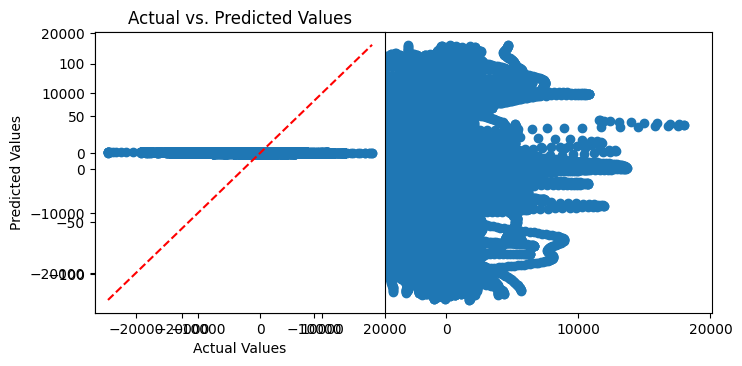

Mean Squared Error (MSE): 4.8897e+06
Mean Absolute Error (MAE): 1.2376e+03
R-squared (R²) Score: -1.4726e-02


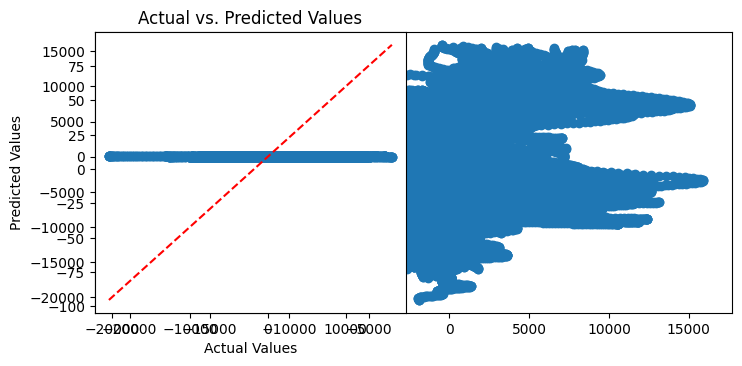

Mean Squared Error (MSE): 4.9783e-01
Mean Absolute Error (MAE): 4.5430e-02
R-squared (R²) Score: 9.9040e-01


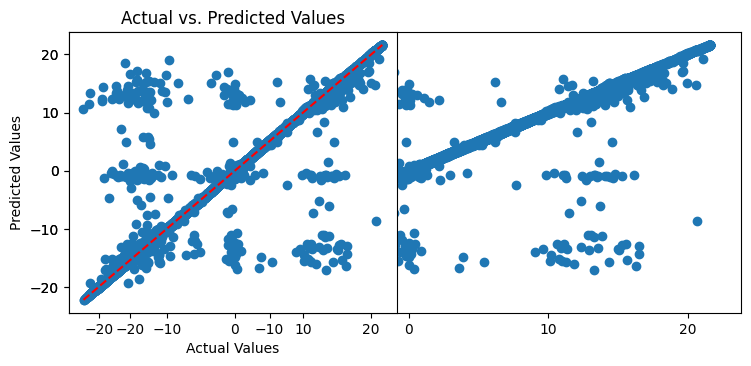

Mean Squared Error (MSE): 1.7211e-01
Mean Absolute Error (MAE): 3.5292e-02
R-squared (R²) Score: 9.8945e-01


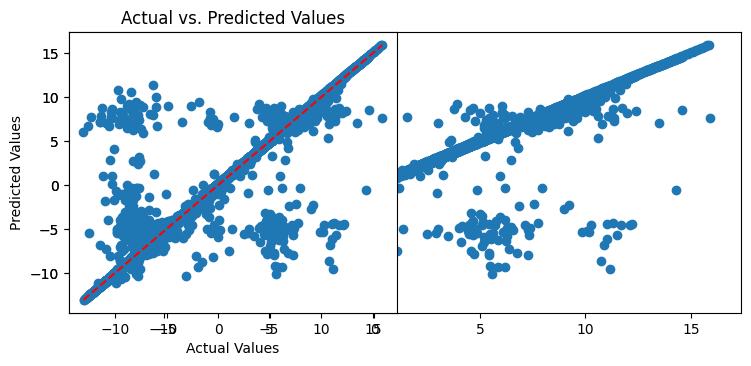

In [9]:
evaluate(s_x_pred, s_x[2:])
evaluate(s_y_pred, s_y[2:])
evaluate(v_x_pred, v_x[2:])
evaluate(v_y_pred, v_y[2:])



Mean Squared Error (MSE): 7.0322e+01
Mean Absolute Error (MAE): 4.3386e+00
R-squared (R²) Score: 9.6832e-01


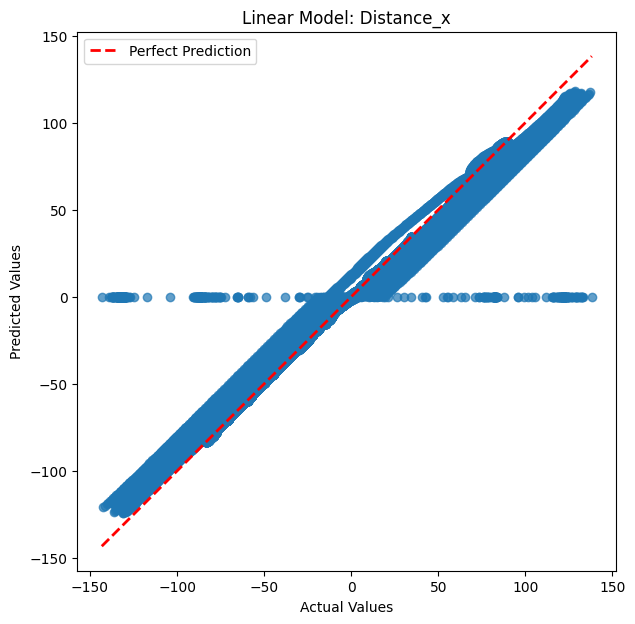

Mean Squared Error (MSE): 2.3272e+01
Mean Absolute Error (MAE): 2.6417e+00
R-squared (R²) Score: 9.7640e-01


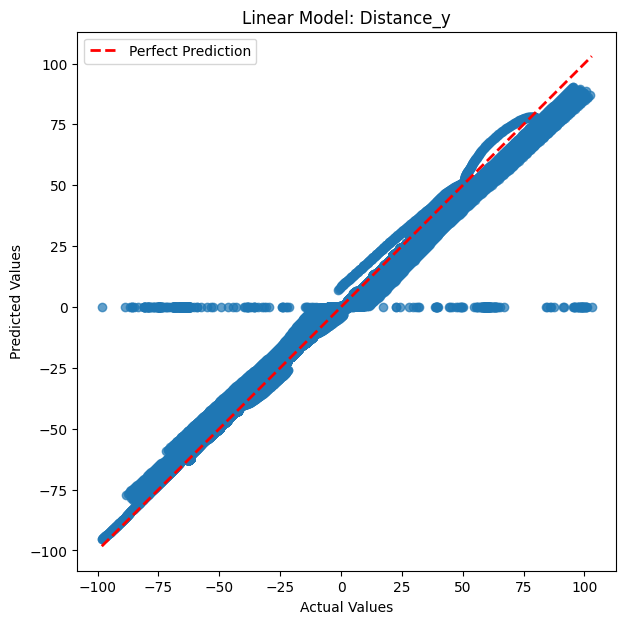

Mean Squared Error (MSE): 4.9784e-01
Mean Absolute Error (MAE): 4.5471e-02
R-squared (R²) Score: 9.9040e-01


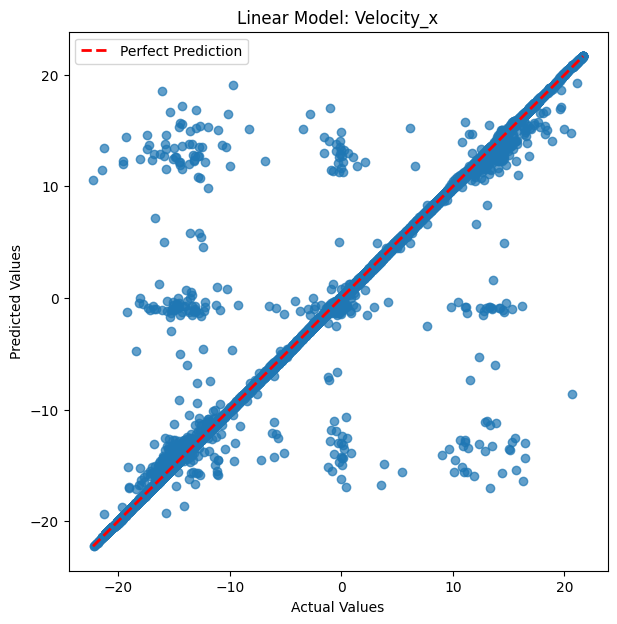

Mean Squared Error (MSE): 1.7211e-01
Mean Absolute Error (MAE): 3.5334e-02
R-squared (R²) Score: 9.8945e-01


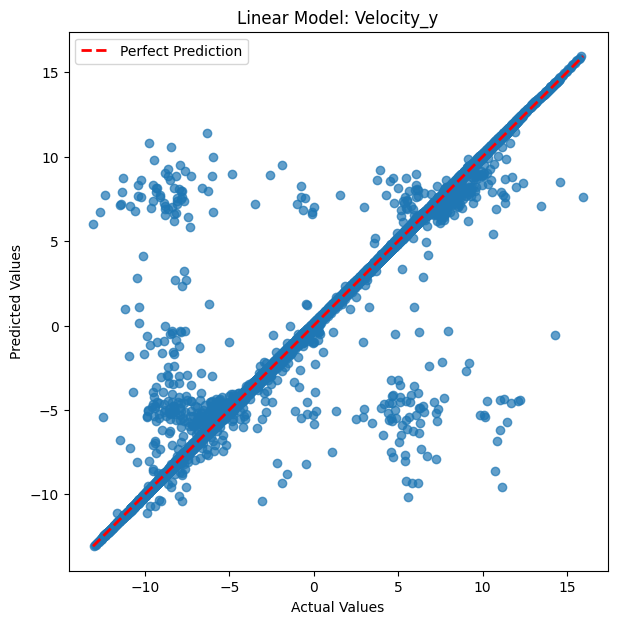

In [19]:

save_dir = '/home/ali/tum/motion_planning/social_ai_practical_course/reports/figures/acceleration_mod'
evaluate_and_save(s_x_pred, s_x[2:], os.path.join(save_dir, 'acceleration_mod_dist_x'), 'Linear Model: Distance_x')
evaluate_and_save(s_y_pred, s_y[2:], os.path.join(save_dir, 'acceleration_mod_dist_y'), 'Linear Model: Distance_y')
evaluate_and_save(v_x_pred, v_x[2:], os.path.join(save_dir,  'acceleration_mod_vel_x'), 'Linear Model: Velocity_x')
evaluate_and_save(v_y_pred, v_y[2:], os.path.join(save_dir,  'acceleration_mod_vel_y'), 'Linear Model: Velocity_y')



In [ ]:
dt = 1
s_x_pred = s_x[1:-1] + dt * v_x[1:-1] + c_3 * a_x[1:-1] + c_4 * a_x[0:-2]
s_y_pred = s_y[1:-1] + dt * v_y[1:-1] + c_3 * a_y[1:-1] + c_4 * a_y[0:-2]



In [21]:
display(s_x[1:-1])
display(dt * v_x[1:-1] )
display(c_3 * a_x[1:-1] )
display(c_4 * a_x[0:-2])

array([-0.04689, -0.09698, -0.14658, ..., 16.91658, 17.46545, 18.01444])

array([-1.20844, -1.20806, -1.20726, ..., 13.7343 , 13.73744, 13.7408 ])

array([-1.12230063e-09, -1.32247976e-09, -1.62552874e-09, ...,
        7.96916853e-09,  7.95248694e-09,  7.95063343e-09])

array([-50.33877765, -58.22374378, -68.60882112, ..., 415.83580509,
       413.431852  , 412.56642889])

In [19]:
dt = 0.04

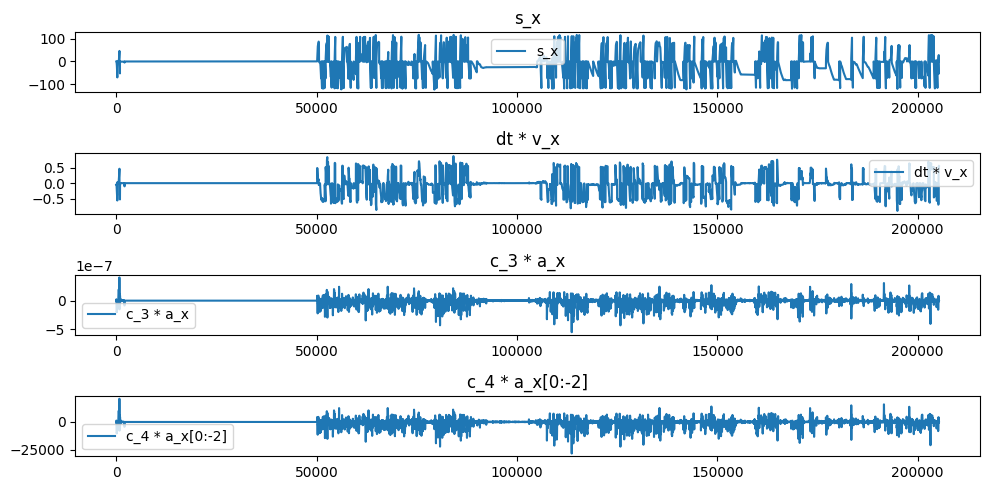

In [20]:
import matplotlib.pyplot as plt

# Assuming s_x, dt, v_x, c_3, and a_x are already defined

# Plotting s_x
plt.figure(figsize=(10, 5))
plt.subplot(411)
plt.plot(s_x[1:-1], label='s_x')
plt.title('s_x')
plt.legend()

# Plotting dt * v_x
plt.subplot(412)
plt.plot(dt * v_x[1:-1], label='dt * v_x')
plt.title('dt * v_x')
plt.legend()

# Plotting c_3 * a_x
plt.subplot(413)
plt.plot(c_3 * a_x[1:-1], label='c_3 * a_x')
plt.title('c_3 * a_x')
plt.legend()

# Plotting c_4 * a_x[0:-2]
plt.subplot(414)
plt.plot(c_4 * a_x[0:-2], label='c_4 * a_x[0:-2]')
plt.title('c_4 * a_x[0:-2]')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
s_x[:]

array([ 0.     , -0.04689, -0.09698, ..., 17.46545, 18.01444, 18.56397])